3. Group Proposed Project (10 marks)
3.1 At this point, you understand the data quite well. Carry out the analysis you proposed
in your group project proposal. You should use the dataset given but you may also use
additional datasets to supplement your analysis, look at unaggregated data, etc. Please
be sure to justify why the analysis is useful and interesting in the context of a data science
project. Note that you are not limited to the initial proposal and are free to expand on
it.
3.2 Based on the insights derived from the analysis, suggest a practical action that can be
taken (i.e., an action that can be taken to benefit society. Do not suggest actions such as
hyperparameter tuning here).

In [47]:
import requests
import json
import pandas as pd
from datetime import datetime
from time import sleep
import os
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from sklearn import datasets, metrics
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert to datetime iso
def toIso(dt):
    return datetime.fromisoformat(dt)

def carparkApiCall(year, month, day, hour, minute, second, error_count):
    def find_local_file(year, month, day, hour, fDir):
        myDir = Path('./data/')
        filePaths = [file for file in myDir.iterdir() if file.name.startswith(f'{year}{month}{day}T{hour.zfill(2)}')]
        is_file_local = False
        for file in filePaths:
            if os.path.isfile(file): #check if file exist
                open(file, 'r')
                fDir = file
                is_file_local = True
                break
        return fDir,is_file_local

    def print_api_error(year, month, day, hour, minute, second, error_count, data):
        print(data)
        print(year,'/', month, '/', day, 'T', hour, minute, second)
        print("error count:", error_count)

    def write_to_file(fDir, data):
        timestamp = data["items"][0]["timestamp"]
        data = data["items"][0]["carpark_data"]
                #create file if response is valid
        os.makedirs(os.path.dirname('./data/'), exist_ok=True)
        with open(fDir, 'w') as fp:
            json.dump(data, fp)
        return data

    def read_from_file(fDir):
        # read from file    
        df = pd.read_json(fDir)
        for heading in ("total_lots","lot_type","lots_available"):
            df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
        
        # Transform data
        df = df.drop(["carpark_info"], axis=1)
        df['update_datetime'] = df['update_datetime'].apply(toIso)
        df["lots_available"] = df["lots_available"].astype(int)
        df["total_lots"] = df["total_lots"].astype(int)
        return df
    
    max_fail_count = 50
    fDir = f'./data/{year}{month}{day}T{hour.zfill(2)}{minute.zfill(2)}{second.zfill(2)}.json'
    fDir, is_file_local = find_local_file(year, month, day, hour, fDir)
    
    if not is_file_local: # If file doesn't exist, api call
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
        response_API = requests.get(site)
        data = response_API.text
        data = json.loads(data)
        
        #check if response is valid
        if response_API.ok and "items" in data and "timestamp" in data["items"][0] and "carpark_data" in data["items"][0]:
            data = write_to_file(fDir, data)
        else:
            error_count+=1
            print_api_error(year, month, day, hour, minute, second, error_count, data)
            if error_count<=max_fail_count:
                return carparkApiCall(year, month, day, hour, minute, second, error_count)
            else:
                f'Api call failed more than {max_fail_count} times :('
            
    df = read_from_file(fDir)
    return df

# Calculate average availability in percentage
def avrAvail(df):
    df["availability_percentage"] = df["lots_available"]/df["total_lots"]
    return df["availability_percentage"]

def addDayHour(df, day, hour):
    df["day"] = day
    df["hour"] = hour
    return df

def removeCountTotalAvail(df):
    df = df.drop(columns = ['lots_available', 'total_lots', 'availability_percentage'])
    return df

def removeXY(df):
    df = df.drop(columns = ['x_coord', 'y_coord'])
    return df

In [48]:
# start date 1 Jan 2022 0001

year = 2022
month = 8
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
# total_hrs = 24*7*20 #24 hours, 7 days a week, 20 weeks
total_hrs = 1

data = None
# generate data
for hr in range(total_hrs):
    dt = dt + dt_interval
    try:
        data = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
    except:
        print(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second))

In [49]:
data.head()

,carpark_number,update_datetime,total_lots,lot_type,lots_available
0,HE12,2022-08-01 00:59:39,105,C,64
1,HLM,2022-08-01 00:59:33,583,C,503
2,RHM,2022-08-01 00:59:39,329,C,121
3,BM29,2022-08-01 00:59:50,97,C,84
4,Q81,2022-08-01 00:59:30,96,C,78


In [50]:
import csv
carpark_rates_dir = f'./data/hdb-carpark-information.csv'
df = pd.read_csv(carpark_rates_dir) 
df[["car_park_no","x_coord","y_coord"]]

,car_park_no,x_coord,y_coord
0,ACB,30314.7936,31490.4942
1,ACM,33758.4143,33695.5198
2,AH1,29257.7203,34500.3599
3,AK19,28185.4359,39012.6664
4,AK31,29482.0290,38684.1754
...,...,...,...
2177,Y77M,29850.1522,45576.0125
2178,Y78M,30057.2209,45166.4820
2179,Y8,27772.9219,45686.2734
2180,Y82M,29935.5818,45679.7181


In [51]:
carparks = set()
location = dict()
for index,row in df[["car_park_no","x_coord","y_coord"]].iterrows():
    carparks.add(row["car_park_no"])
    if row["car_park_no"] not in location:
        location[row["car_park_no"]] = [row["x_coord"],row["y_coord"]]
print(len(carparks),len(location))

2182 2182


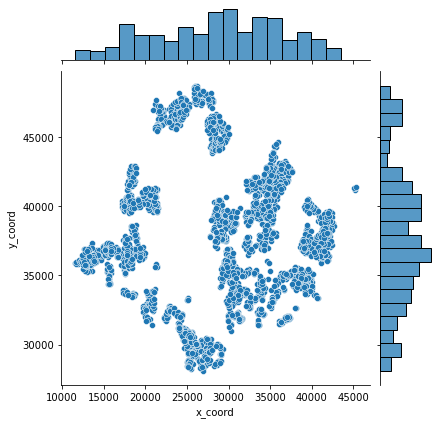

In [52]:
import seaborn as sns
sns.jointplot(data=df,x='x_coord',y='y_coord')

<AxesSubplot:xlabel='x_coord', ylabel='y_coord'>

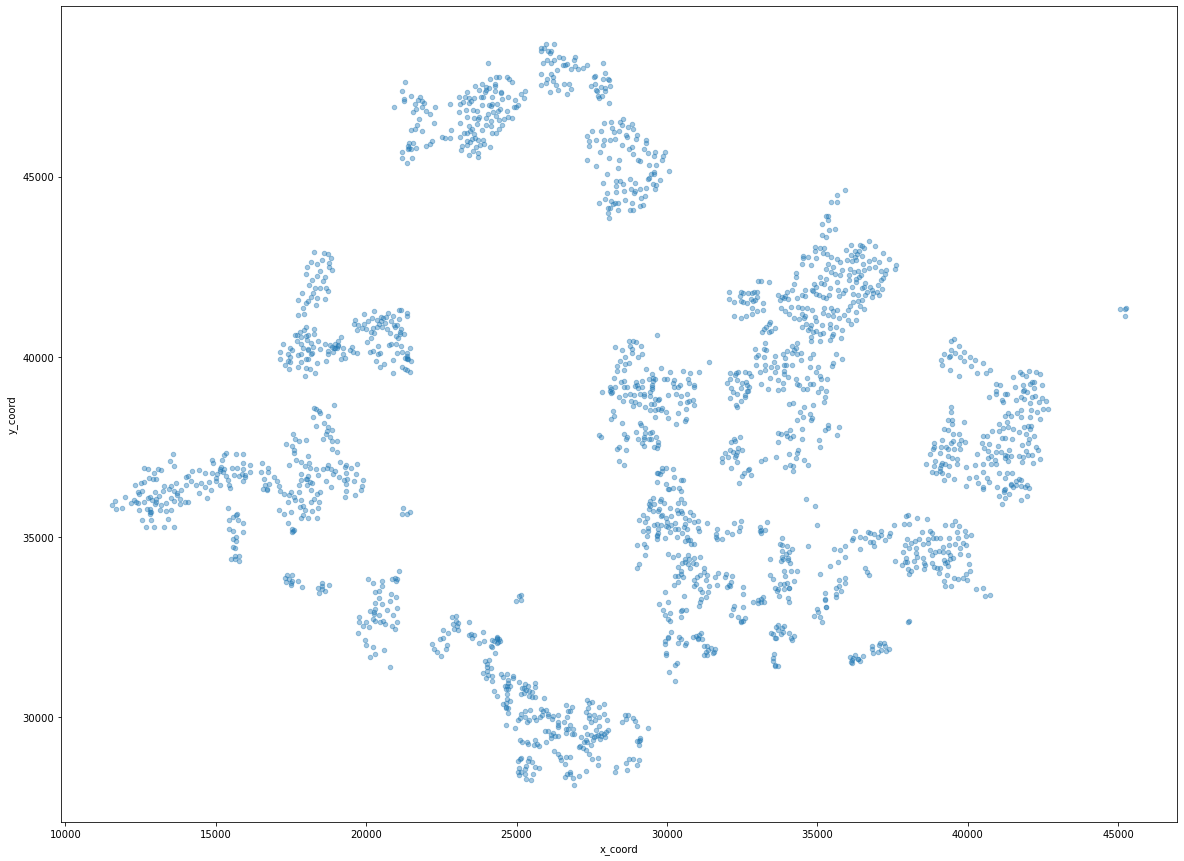

In [53]:
df.plot(x="x_coord",y="y_coord",kind="scatter",alpha=0.4,figsize=(20,15))

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[["x_coord_T","y_coord_T"]] = scaler.fit_transform(df[["x_coord","y_coord"]])

In [55]:
from sklearn.cluster import KMeans
def optimise_k_means(data,max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize = (10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

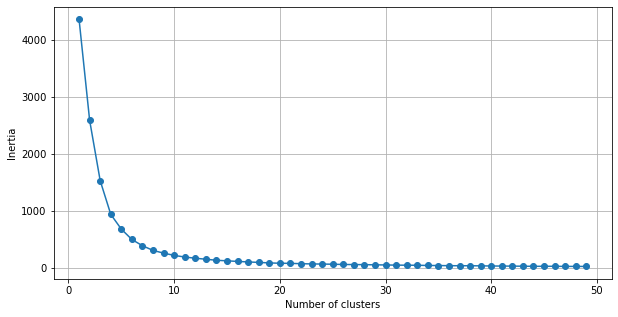

In [56]:
optimise_k_means(df[["x_coord_T","y_coord_T"]],50)

In [57]:
clusters = 50
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(df[["x_coord_T","y_coord_T"]])

KMeans(n_clusters=50)

In [58]:
df["kmeans"] = kmeans.labels_
df[["car_park_no","x_coord","y_coord","kmeans"]]

,car_park_no,x_coord,y_coord,kmeans
0,ACB,30314.7936,31490.4942,30
1,ACM,33758.4143,33695.5198,36
2,AH1,29257.7203,34500.3599,11
3,AK19,28185.4359,39012.6664,16
4,AK31,29482.0290,38684.1754,16
...,...,...,...,...
2177,Y77M,29850.1522,45576.0125,7
2178,Y78M,30057.2209,45166.4820,7
2179,Y8,27772.9219,45686.2734,26
2180,Y82M,29935.5818,45679.7181,7


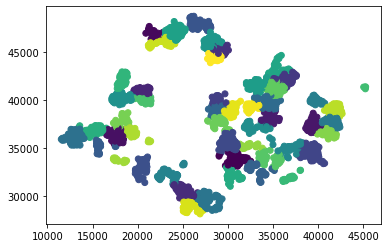

In [59]:
plt.scatter(x=df["x_coord"],y=df["y_coord"],c=df["kmeans"])
plt.show()

In [60]:
df = df[["car_park_no","x_coord","y_coord","kmeans"]]

In [61]:
def merge_on_col(df1,df2,col1,col2):
    return pd.merge(df1, df2, left_on=col1, right_on=col2, how='right').drop(col1, axis=1)

In [62]:
new_df = merge_on_col(df,data,"car_park_no","carpark_number")

In [63]:
new_df1 = new_df.groupby(["kmeans"])
new_df1.sum()

,x_coord,y_coord,total_lots,lots_available
kmeans,,,,
0.0,1.576505e+06,1.726615e+06,12155,5012
1.0,4.988826e+05,1.078464e+06,8672,2602
2.0,9.015947e+05,1.849255e+06,16299,6498
3.0,1.809229e+06,1.720747e+06,19109,9275
4.0,7.912057e+05,8.777497e+05,6728,2782
5.0,8.624351e+05,1.717033e+06,22776,13217
6.0,1.239572e+06,1.490824e+06,12547,6536
7.0,7.353917e+05,1.130061e+06,9057,2935
8.0,2.150936e+06,2.485662e+06,25458,11413


In [64]:
# start date 1 Jan 2022 0001

year = 2022
month = 1
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
total_hrs = 24*7*20 #24 hours, 7 days a week, 20 weeks

# day of week,time of day
train_x = []
# avalibility percentage
train_y = []
# generate data, [day,month]
public_holidays = [[1,2], [2,2], [15,4], [2,5], [3,5], [3,16]]
for hr in range(total_hrs):
    dt = dt + dt_interval
    if [dt.day, dt.month] in public_holidays:
        print(f"{[dt.day, dt.month]} omitted as it is a public holiday on a weekday")
        continue
    try:
        apival = merge_on_col(df, carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0), "car_park_no", "carpark_number")
        apival = apival.groupby(["kmeans"]).sum().dropna(how='all')
        train_y.append(avrAvail(apival)) 
        train_x.append(addDayHour(removeXY(removeCountTotalAvail(apival)), dt.weekday() , dt.hour))
        
    except Exception as e:
        print("exception occurred at")
        print(e)
        print(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second))

[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a public holiday on a weekday
[1, 2] omitted as it is a pu

In [65]:
# consolidate test date

year = 2022
month = 7
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
total_hrs = 24*60 #24 hours, 7 days a week, 4 weeks

# day of week,time of day
test_x = []
# avalibility percentage
test_y = []
# generate data, [day,month]
public_holidays = [[1,2], [2,2], [15,4], [2,5], [3,5], [3,16]]
for hr in range(total_hrs):
    dt = dt + dt_interval
    if [dt.day, dt.month] in public_holidays:
        print(f"{[dt.day, dt.month]} omitted as it is a public holiday on a weekday")
        continue
    try:
        apival = merge_on_col(df, carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0), "car_park_no", "carpark_number")
        apival = apival.groupby(["kmeans"]).sum().dropna(how='all')
        test_y.append(avrAvail(apival)) 
        test_x.append(addDayHour(removeXY(removeCountTotalAvail(apival)), dt.weekday() , dt.hour))
        
    except Exception as e:
        print("exception occurred at")
        print(e)
        print(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second))

exception occurred at
list index out of range
2022 8 1 0 1 0


In [66]:
print(np.array(train_x).shape) # x contains 3223 separate hours of 50 clusters, each cluster has 5 attributes
print(np.array(train_x)[:,0,:].shape)
print(np.array(train_y).shape) # y contains 3223 separate hours of 50 clusters. I want to fix my cluster
print(np.array(train_y)[:,0].shape)

(3233, 50, 2)
(3233, 2)
(3233, 50)
(3233,)


In [67]:
from sklearn.tree import DecisionTreeRegressor 

dt_models = []

for i in range(0,50):
# create a regressor object
    start = 1
    depth = start
    final_depth = 0
    mse_arr = []
    mse = 99999999999999999

    
    while depth<=10: 
        temp_regressor = DecisionTreeRegressor(max_depth=depth) 
        # fit the regressor with X and Y data
        trn_x = np.array(train_x)[:,i,:]
        trn_y = np.array(train_y)[:,i]
        tst_x = np.array(test_x)[:,i,:]
        tst_y = np.array(test_y)[:,i]
        temp_regressor.fit(np.array(trn_x), np.array(trn_y))
        #5 Predicting a new result
        predicted = temp_regressor.predict(np.asarray(tst_x))
        temp_mse = mean_squared_error(np.array(tst_y), predicted)
        mse_arr.append(temp_mse)
        if mse - temp_mse > 0.0001: # arbitrary number to prevent overfitting  
            mse = temp_mse
            regressor = temp_regressor
            final_depth = depth
        depth += 1

    print(f"cluster num: {i} mse: {mse} depth: {final_depth}")
    # plt.plot([x for x in range(start,len(mse_arr)+start)], mse_arr, color="blue", linewidth=3)
    # plt.grid(True)
    # plt.xlabel("Depth")
    # plt.ylabel("MSE")
    # plt.show()
    dt_models.append(temp_regressor)

cluster num: 0 mse: 0.00046713108742115313 depth: 6
cluster num: 1 mse: 0.0007691826196639233 depth: 7
cluster num: 2 mse: 0.0008416116158518575 depth: 5
cluster num: 3 mse: 0.0022180591473599594 depth: 8
cluster num: 4 mse: 0.0013285349780977904 depth: 7
cluster num: 5 mse: 0.00037814284968011553 depth: 8
cluster num: 6 mse: 0.0002112261516984743 depth: 1
cluster num: 7 mse: 0.0016804058251237626 depth: 6
cluster num: 8 mse: 0.0009174454854879622 depth: 7
cluster num: 9 mse: 0.0008760534481710244 depth: 7
cluster num: 10 mse: 0.0006576590065137123 depth: 5
cluster num: 11 mse: 0.00045028529952430486 depth: 5
cluster num: 12 mse: 0.00048551257957732646 depth: 3
cluster num: 13 mse: 0.00047946300682720597 depth: 5
cluster num: 14 mse: 0.0008509712078823943 depth: 9
cluster num: 15 mse: 0.004222830689634005 depth: 5
cluster num: 16 mse: 0.000730991976545686 depth: 5
cluster num: 17 mse: 0.00230556302352131 depth: 7
cluster num: 18 mse: 0.0006403366212263598 depth: 7
cluster num: 19 mse: 

mse: 0.00043230908602433243


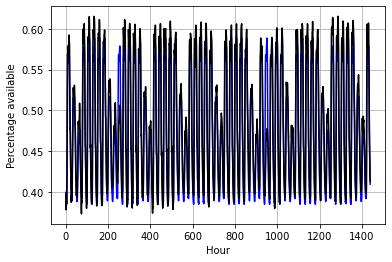

mse: 0.0007450733488040249


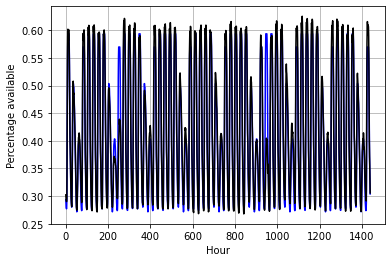

mse: 0.0007678501609612385


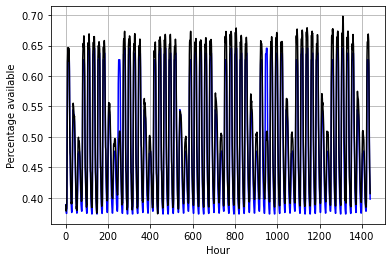

mse: 0.0022171445122879316


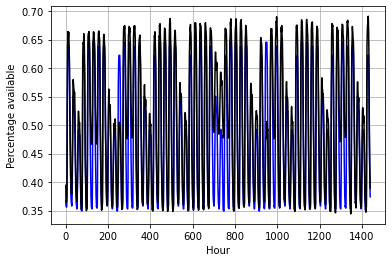

mse: 0.0013283293107506603


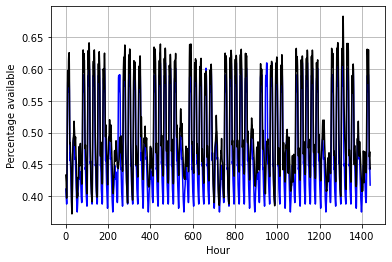

mse: 0.0003692788565111737


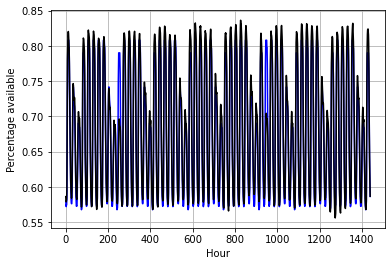

mse: 0.00018257063724558056


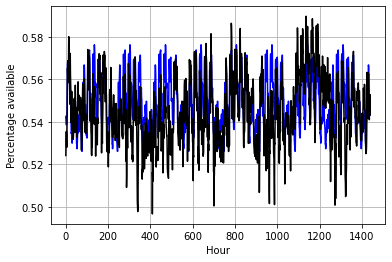

mse: 0.00158612992898042


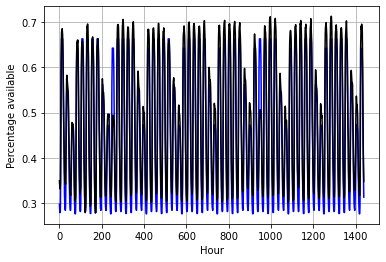

mse: 0.0008873969145139052


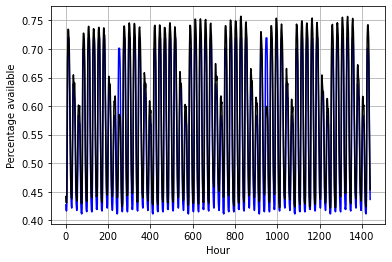

mse: 0.0008460339106646581


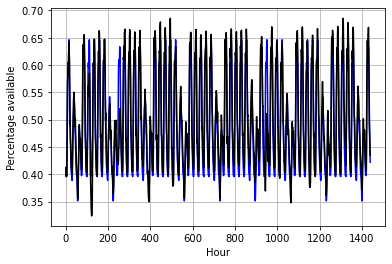

mse: 0.0005908826421597719


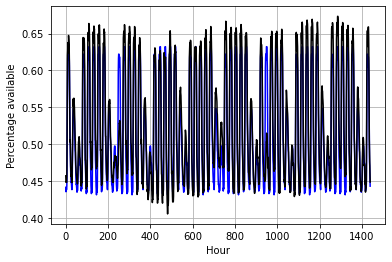

mse: 0.00042395678353931933


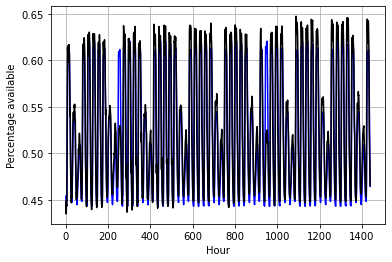

mse: 0.00041523261487781107


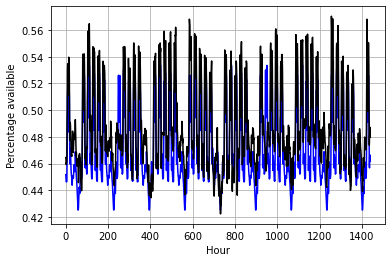

mse: 0.0003812542783523371


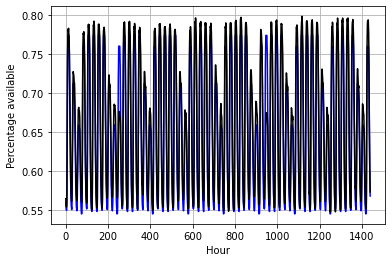

mse: 0.0008474485066025015


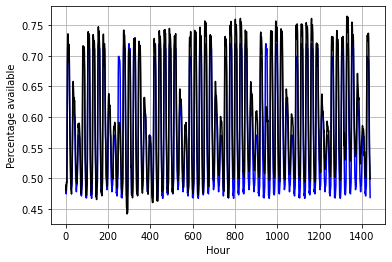

mse: 0.004222709317166148


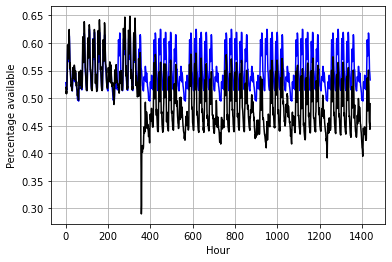

mse: 0.0007044242948853626


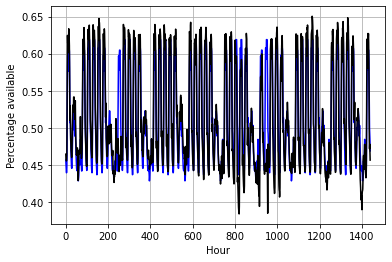

mse: 0.002279613184061239


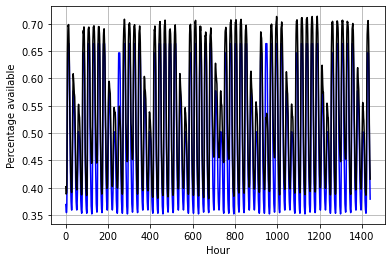

mse: 0.0006181414832991186


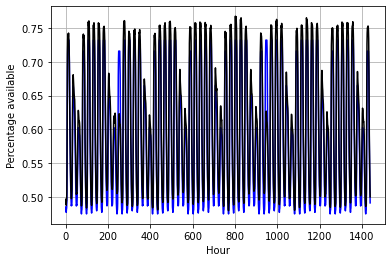

mse: 0.000649426689981178


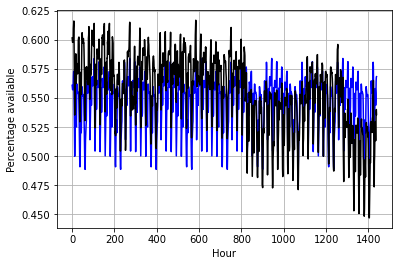

mse: 0.000914886603706063


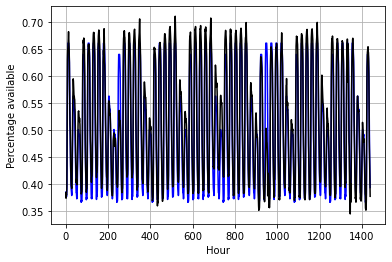

mse: 0.0009854338473984532


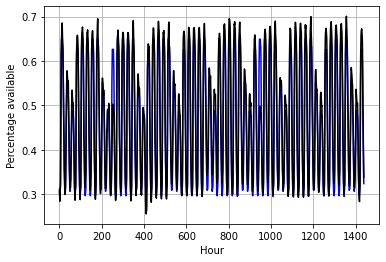

mse: 0.000460550617770594


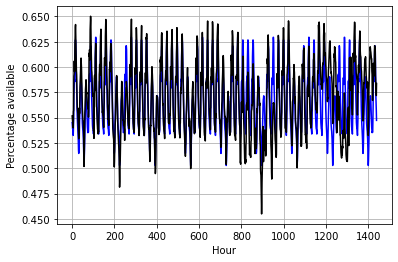

mse: 0.000579151302910977


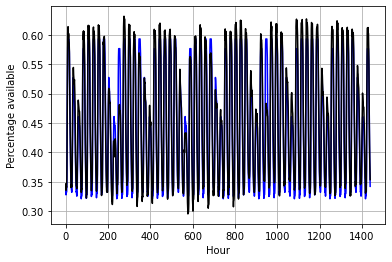

mse: 0.0007016089264596995


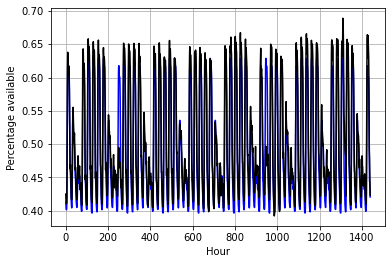

mse: 0.0005938837749921961


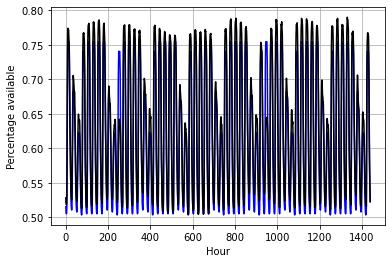

mse: 0.0012422560944972097


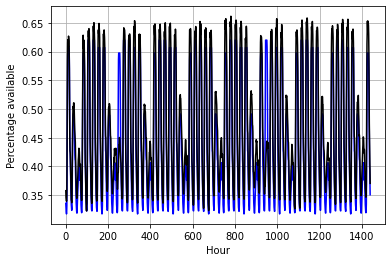

mse: 0.0009100903570098127


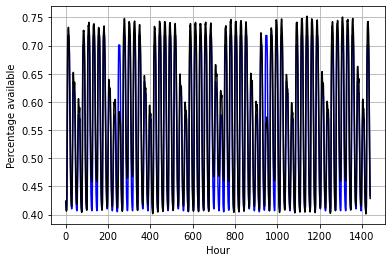

mse: 0.0005916704903214531


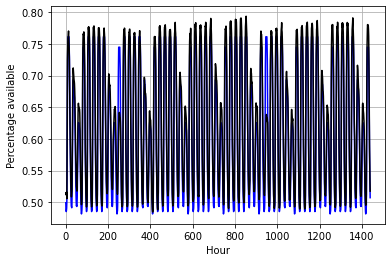

mse: 0.001318425440697556


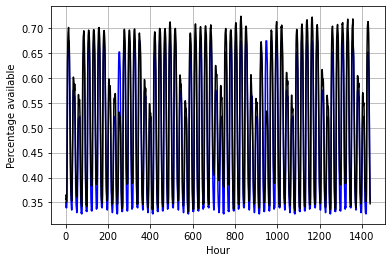

mse: 0.00036085412987537263


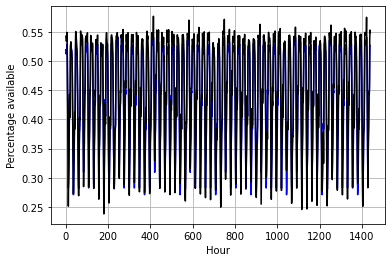

mse: 0.0008805833385673971


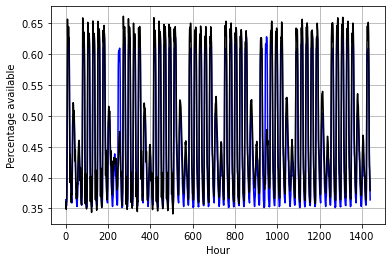

mse: 0.00031523489548071086


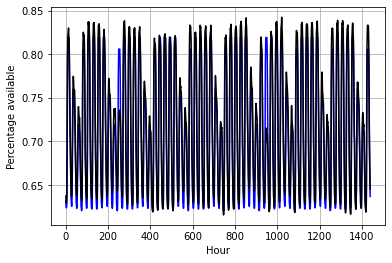

mse: 0.0005596775640131606


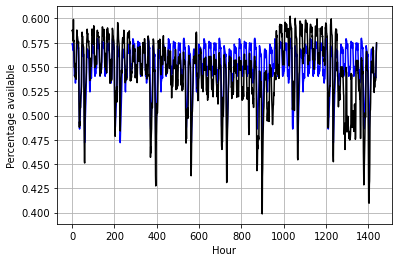

mse: 0.021143283136447512


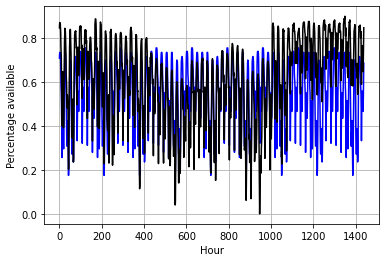

mse: 0.001465285398910637


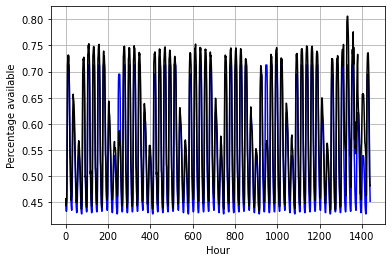

mse: 0.0003850274405028698


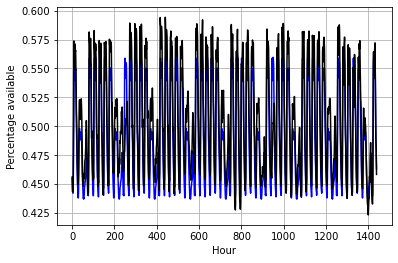

mse: 0.00048449018751373237


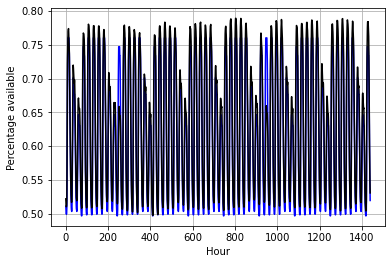

mse: 0.00041347413574631696


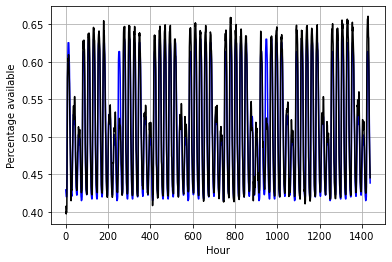

mse: 0.0011689638512285875


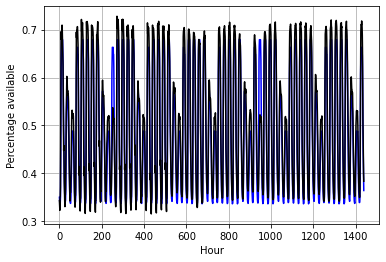

mse: 0.0011614656249515128


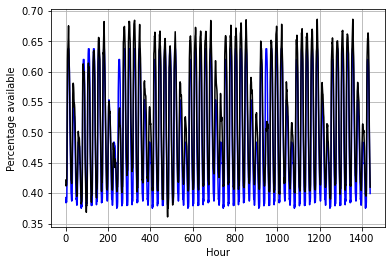

mse: 0.0008054266494438744


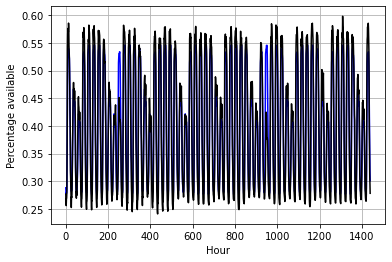

mse: 0.0008472766373992331


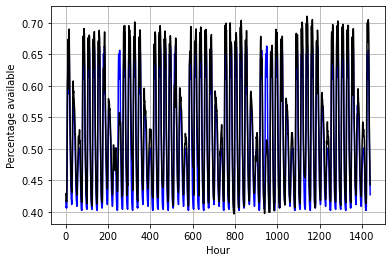

mse: 0.0008441618695845043


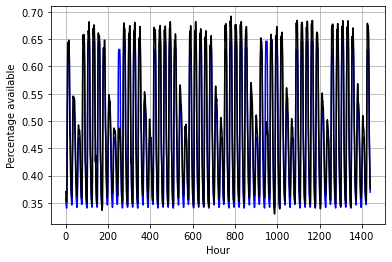

mse: 0.0008765646629293237


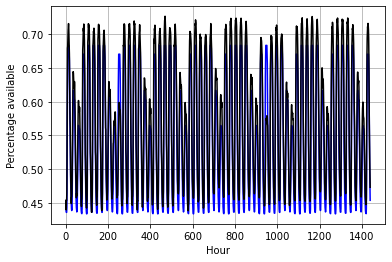

mse: 0.0007739322995469613


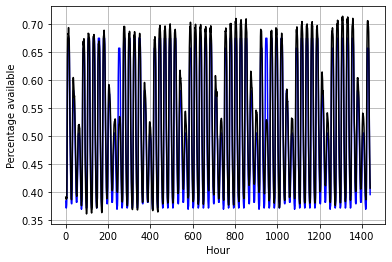

mse: 0.00040692720556643455


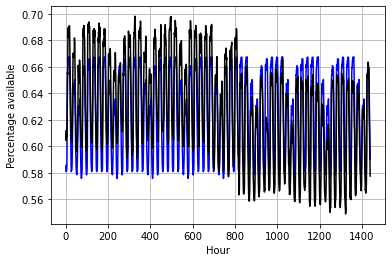

mse: 0.0011980691690512775


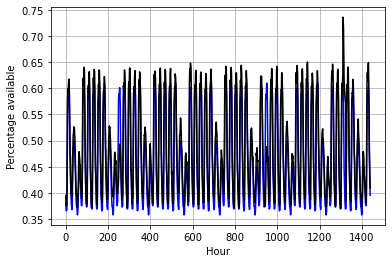

mse: 0.0008604077958375421


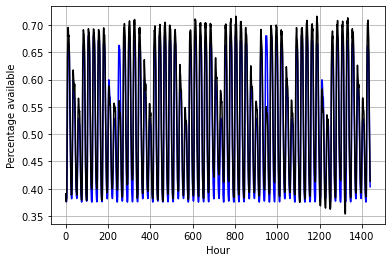

mse: 0.0012421610663259585


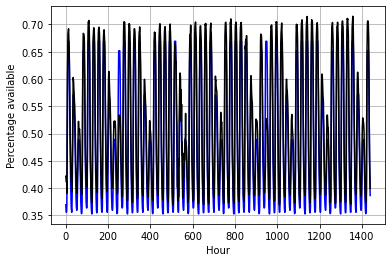

In [68]:
for i in range(clusters):
    predicted = dt_models[i].predict(np.array(test_x)[:,i,:])
    print(f"mse: {mean_squared_error(np.array(test_y)[:,i], predicted)}")

    plt.plot([x for x in range(len(predicted))], predicted, color="blue", label = 'predicted') # predicted
    # plt.plot(x_grid, predicted, color="blue", linewidth=3)
    plt.plot([y for y in range(len(np.array(test_y)[:,i]))], np.array(test_y)[:,i], color="black", label ='actual') #actual
    plt.grid(True)
    plt.xlabel("Hour")
    plt.ylabel("Percentage available")
    # plt.legend(loc='upper left')
    plt.show()
    

In [72]:
def get_cluster_avail_from_carparknum(carpark_number, time, dt_models , cluster_list):
    carpark = cluster_list.loc[cluster_list["car_park_no"] == carpark_number]["kmeans"]
    if carpark.empty:
        return "Carpark number does not exist"
    day = time.weekday()
    hour = time.hour
    pred = dt_models[carpark[0]].predict(np.array([[day, hour]]))
    return pred[0]

# year = 2022
# month = 10
# day = 5
# hour = 20
# minute = 1
# second = 0

# dt = datetime(year, month, day, hour, minute, second)
# get_cluster_avail_from_carparknum("ACB", dt, dt_models, df)

0.4241709255194924